In [66]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [121]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']
splits = ['train', 'test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
for dset in tqdm(dsets):
    for split in splits:
        df = data.get_data(dset=dset)
        df = df[~(df.short | df.long | df.hotspots)]
#         df = df[df.valid]
#         df = df[df.lifetime > 15] # only keep hard tracks
        df = df[df.cell_num.isin(config.DSETS[dset][split])] # exclude held-out test data
        feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        length = 40
        df['X_same_length'] = [features.downsample(df.iloc[i]['X'], length)
                               for i in range(len(df))] # downsampling
        # normalize tracks
        df = features.normalize_track(df, track='X_same_length')

        # regression response
        df = train_reg.add_sig_mean(df)     

        # remove extraneous feats
        # df = df[feat_names + meta]
#         df = df.dropna() 

        # normalize features
        for feat in feat_names:
            if 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)

        dfs[(dset, split)] = deepcopy(df)
        # merge all dsets
    #     if df_full is None:
    #         df_full = deepcopy(df)
    #     else:
    #         df_full = df_full.merge(df)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:03<00:14,  3.66s/it]

 40%|████      | 2/5 [00:06<00:09,  3.29s/it]../src/train_reg.py:83: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05
../src/train_reg.py:83: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


 60%|██████    | 3/5 [00:16<00:11,  5.50s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.20s/it]

100%|██████████| 5/5 [00:25<00:00,  5.00s/it]

## train neural net

In [102]:
df_train = dfs[('clath_aux+gak_a7d2_new', 'train')]
print(os.listdir(DIR_RESULTS))
out_dir = f'{DIR_RESULTS}/dec13_deep_best'
# out_dir = f'results/regression/deep_learning/Dec11'

['mar19_2', 'maxconv', 'aug19_binary1', 'mar19_1', 'clips', 'dec12_deep_H=80', 'dec8_1', 'dec10_deep', 'apr28_1', 'dec13_deep_best', 'may7_1', 'dec10_cnn', 'may6_1', 'mar19_3', 'dec12_deep', 'dec12_deep_H=20', 'nov16', 'dec10_lstm']


In [ ]:
os.makedirs(out_dir, exist_ok=True)
outcome_def = 'Y_sig_mean_normalized'
num_epochs = 100
num_hidden = 40
for model_type in ['nn_lstm']: #['nn_cnn', 'fcnn', 'nn_lstm']: # = 'nn_cnn' # 'nn_lstm', 'fcnn', 'nn_cnn', 'nn_attention'
    train_reg.train_reg(df_train,
                        feat_names=feat_names,
                        track_name='X_same_length_normalized',
                        model_type=model_type, 
                        outcome_def=outcome_def,
                        out_name=oj(out_dir, f'{dset}_{outcome_def}_{model_type}_{num_epochs}_{num_hidden}.pkl'),
                        fcnn_hidden_neurons=num_hidden,
                        fcnn_epochs=num_epochs)

# analyze results

In [23]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r[['pearsonr', 'r2']]

{'r2': [0.3410249004640089, 0.3208547273943092, 0.4126897499403642, 0.3594438570984312, 0.36538168636939417, 0.408612136123226, 0.3859741881617027, 0.4261156649998624], 'pearsonr': [0.5854548719270554, 0.56699047930762, 0.6433357214073335, 0.601086041946158, 0.6045239439241363, 0.6392560386371637, 0.6236078945096376, 0.6549200084527723]}
dict_keys(['r2', 'pearsonr'])


,pearsonr,r2
model_type,,
clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40,0.615,0.377


# transfer to classification

In [131]:
results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=17, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

<All keys matched successfully>

clath_aux+gak_a7d2 train 0.5047683923705722 0.7200272479564033
clath_aux+gak_a7d2 test 0.42686567164179107 0.7044776119402985
clath_aux+gak train 0.5961650203370134 0.7280650784427658
clath_aux+gak test 0.525879917184265 0.7536231884057971
clath_aux+gak_new train 0.515695067264574 0.7657813038978958
clath_aux+gak_new test 0.3258426966292135 0.8009630818619583
clath_gak train 0.40261813537675606 0.7199872286079183
clath_gak test 0.4760820045558087 0.7266514806378133


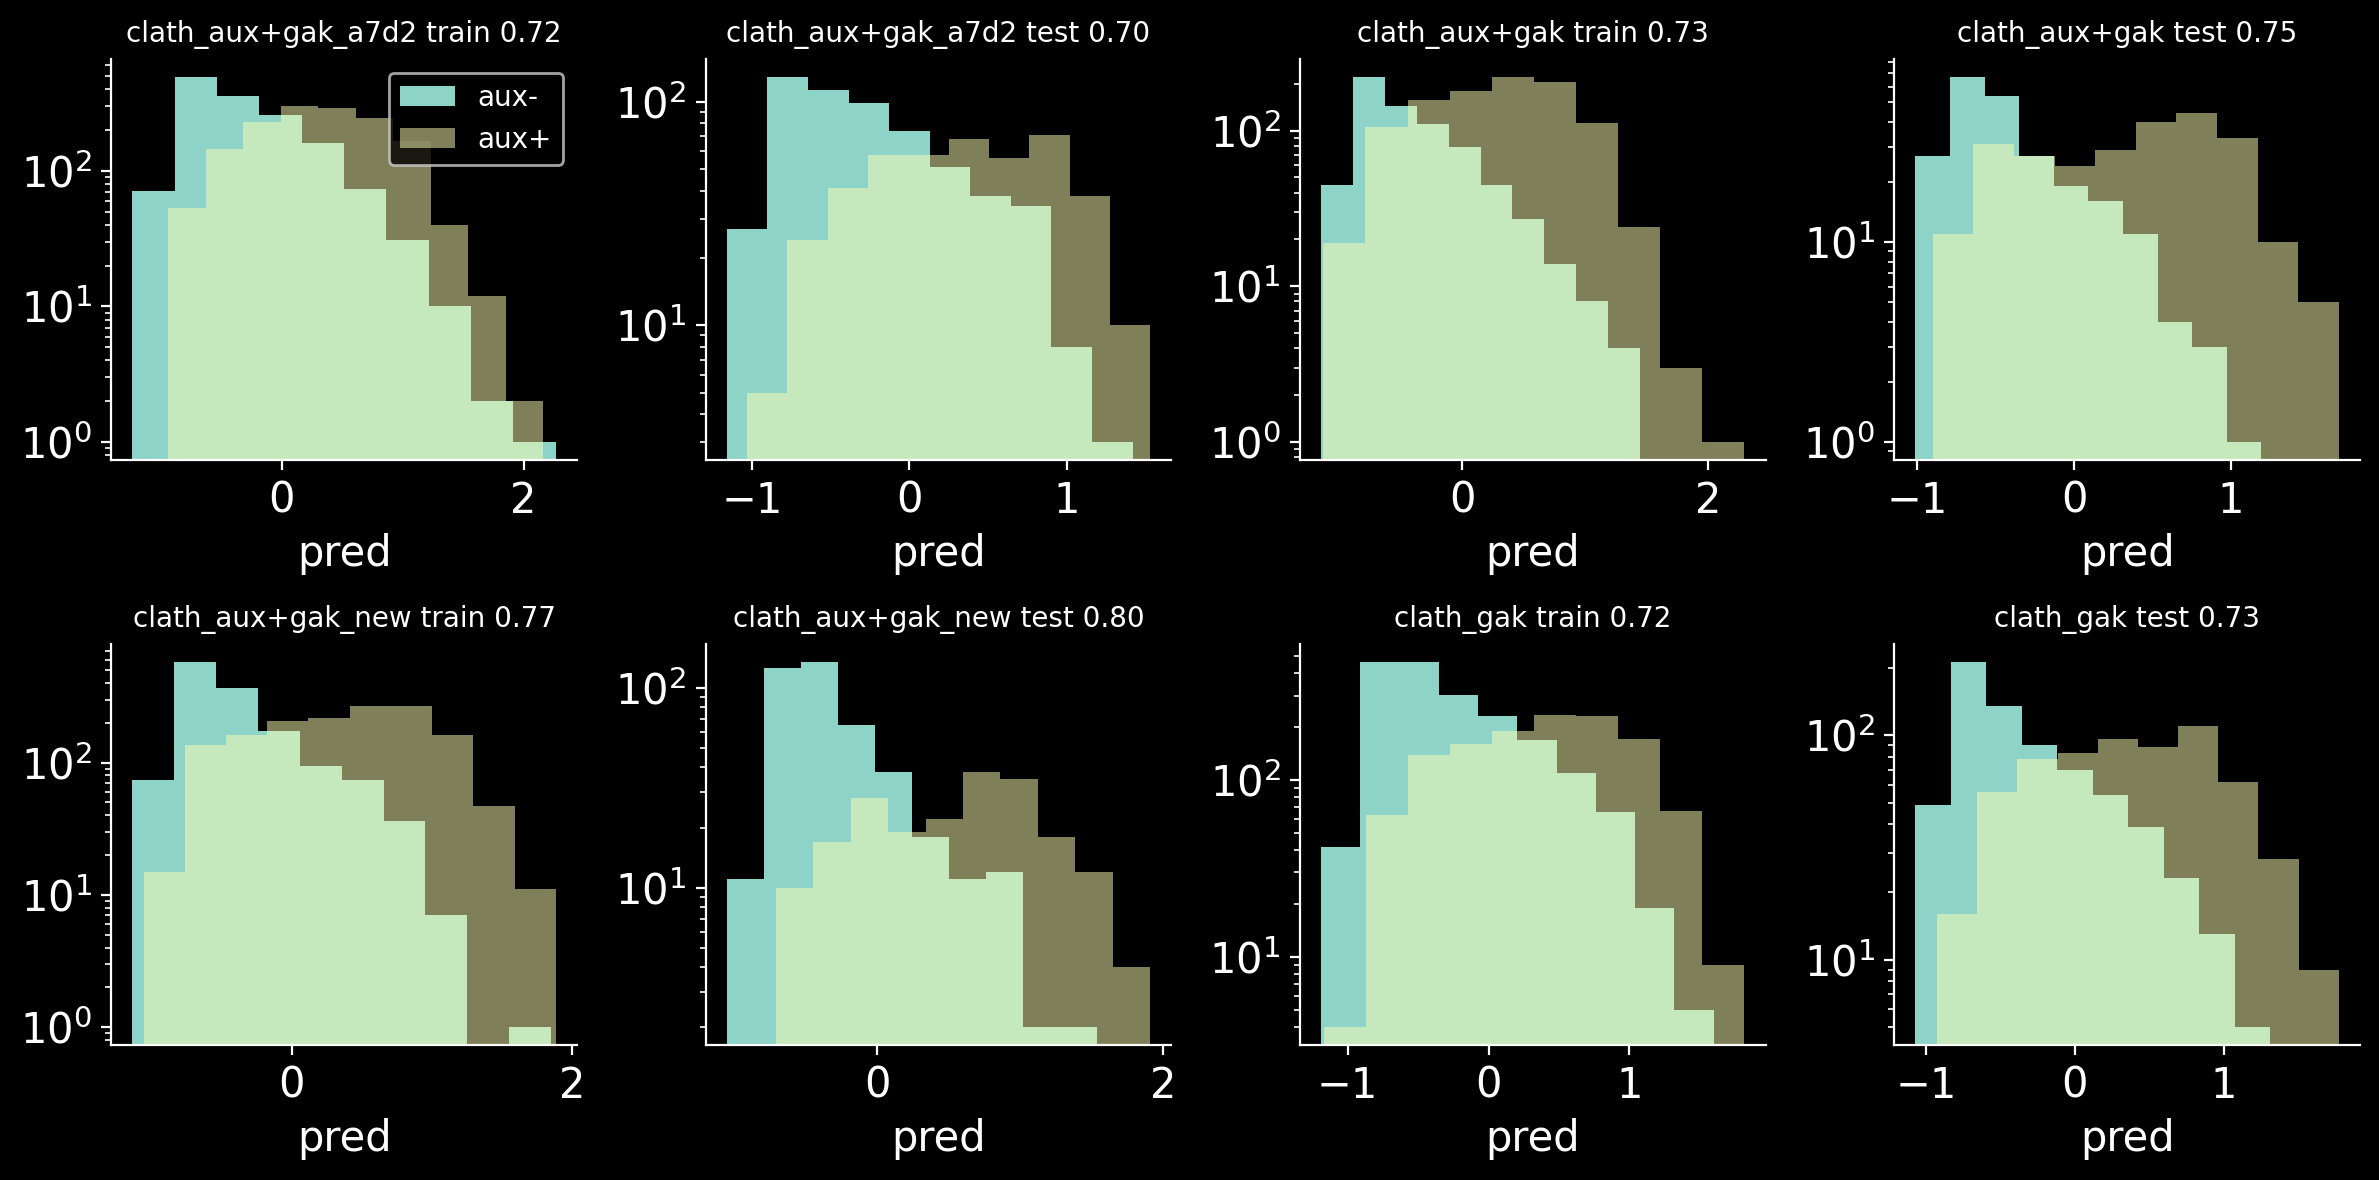

In [132]:
R = 2
C = len(dfs) // 2 - 1

# exclude the training data
ds = {(k, v): dfs[(k, v)]
      for (k, v) in dfs.keys()
      if not k == 'clath_aux+gak_a7d2_new'}


plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    X = df[feat_names]
    y = df['y_consec_thresh']
    preds = dnn.predict(X)
    
    plt.subplot(R, C, i + 1)
    y_pred = (preds > 0).astype(int)
    acc = np.mean(y_pred == y)
#     print(k, v, np.mean(y), acc)
    plt.title(f'{k} {v} {acc:0.2f}', fontsize=10)
    plt.hist(preds[y==0], alpha=1, label='aux-')
    plt.hist(preds[y==1], alpha=0.5, label='aux+')
    plt.yscale('log')
    plt.xlabel('pred')
    
    if i == 0:
        plt.legend()